In [12]:
# keep all import statements up here
import kmertools as kt
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import math
from IPython.display import display
import datetime
import os

In [13]:
# file paths
all_vars = '/Users/simonelongo/Downloads/np_23oct2019results_23Oct2019-1619/all_vars.bed'
all_trans = '/Users/simonelongo/Downloads/np_23oct2019results_23Oct2019-1619/all_transitions.csv'

sing_vars = '/Users/simonelongo/Downloads/np_23oct2019results_23Oct2019-1619/singleton_vars.bed'
sing_trans = '/Users/simonelongo/Downloads/np_23oct2019results_23Oct2019-1619/singleton_transitions.csv'

ns_vars = '/Users/simonelongo/Downloads/np_23oct2019results_23Oct2019-1619/notsingleton_vars.bed'
ns_trans = '/Users/simonelongo/Downloads/np_23oct2019results_23Oct2019-1619/notsingleton_transitions.csv'

Forgot to account for lowercase letters. Correcting that now...

In [14]:
transitions = {'all_transitions':all_trans, 'singleton_transitions':sing_trans, 'not_singleton_transitions':ns_trans}
variants = [all_vars, sing_vars, ns_vars]
new_t = {}
for name, fp in transitions.items():
    df_c = defaultdict(Counter)
    df = pd.read_csv(fp, index_col=0).to_dict('index')
    for k, v in df.items():
        for tr, ct in Counter(v).items():
            df_c[k.upper().strip()][tr] += ct
    new_t[name] = df_c
#merged = pd.DataFrame.from_dict(df_c, orient='index')
#print(merged.shape)
#merged.head() # print(value)

In [15]:
ref_3mer_freq = pd.read_csv('data/ref_genome_kmer_freq.csv', index_col=0)
ref_3mer_freq.columns = ['counts']
ref_3mer_freq.head()

joined_dfs = {}
for name, merged in new_t.items():
    mt = pd.DataFrame.from_dict(merged, orient='index')
    all_data = mt.join(ref_3mer_freq, how='inner')
    joined_dfs[name] = all_data

for name, df in joined_dfs.items():
    print(name)
    print(df.head())

all_transitions
             C          A          G          T     counts
AAA  2498760.0        NaN  4230276.0  1444540.0  109671324
AAC   750652.0        NaN  2849221.0   743652.0   41595680
AAG  1221024.0        NaN  2977126.0   754220.0   56991470
AAT  1250640.0        NaN  6653174.0  1350510.0   71230656
ACA        NaN  2164007.0  1795576.0  6677354.0   57551081
singleton_transitions
             G          C          T          A     counts
AAA  2313890.0  1383827.0   799749.0        NaN  109671324
AAC  1530505.0   407394.0   417837.0        NaN   41595680
AAG  1648989.0   716365.0   434892.0        NaN   56991470
AAT  3325455.0   722803.0   732959.0        NaN   71230656
ACA  1005487.0        NaN  3502351.0  1190424.0   57551081
not_singleton_transitions
             C         A          G          T     counts
AAA  1114933.0       NaN  1916386.0   644791.0  109671324
AAC   343258.0       NaN  1318716.0   325815.0   41595680
AAG   504659.0       NaN  1328137.0   319328.0   56991

In [16]:
# Divide variant context counts by reference counts to obtain relative frequencies
freqs = {}
for name, df in joined_dfs.items():
    freqs[name] = df.iloc[:, 0:4].div(df['counts'], axis=0).sort_index().reindex(sorted(df.columns), axis=1)
for name, df in joined_dfs.items():
    print(name)
    print(df.iloc[:,0:4].head())
    df.iloc[:,0:4].to_csv('gnomadv3_kmer_'+ name +'.csv')

all_transitions
             C          A          G          T
AAA  2498760.0        NaN  4230276.0  1444540.0
AAC   750652.0        NaN  2849221.0   743652.0
AAG  1221024.0        NaN  2977126.0   754220.0
AAT  1250640.0        NaN  6653174.0  1350510.0
ACA        NaN  2164007.0  1795576.0  6677354.0
singleton_transitions
             G          C          T          A
AAA  2313890.0  1383827.0   799749.0        NaN
AAC  1530505.0   407394.0   417837.0        NaN
AAG  1648989.0   716365.0   434892.0        NaN
AAT  3325455.0   722803.0   732959.0        NaN
ACA  1005487.0        NaN  3502351.0  1190424.0
not_singleton_transitions
             C         A          G          T
AAA  1114933.0       NaN  1916386.0   644791.0
AAC   343258.0       NaN  1318716.0   325815.0
AAG   504659.0       NaN  1328137.0   319328.0
AAT   527837.0       NaN  3327719.0   617551.0
ACA        NaN  973583.0   790089.0  3175003.0


Above, we see 3 data frames representing the likelihood of a 3-mer to mutate with respect to the reference genome. The indices are represented by the original sequence on the reference genome and the columns show how many times the central nucleotide changed from the original to the nucleotide in the column.

Now we will compare transition frequencies across the different data frames:

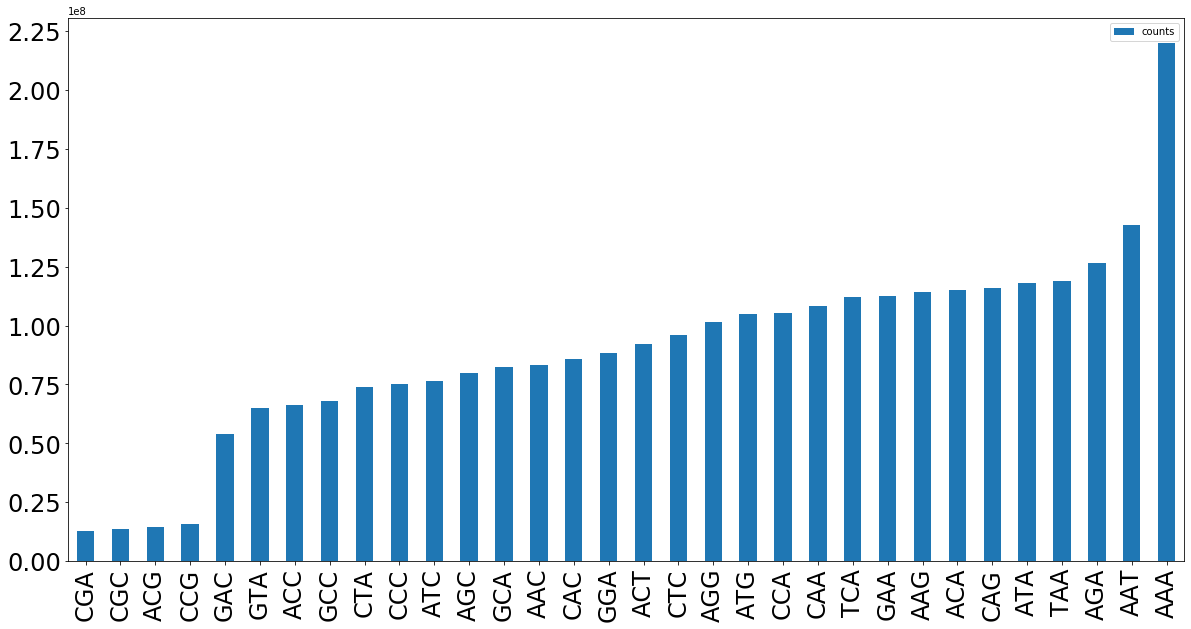

In [17]:
# visualize counts per 3-mer on reference genome
sortedcounts = kt.combine_complements(ref_3mer_freq).sort_values(by='counts')
sortedcounts.plot.bar(y='counts', figsize=(20,10), fontsize=24, yticks=list(range(0, 250_000_000, 25_000_000)))

In [18]:
# treat reverse complementary sequences as identical
combined_freqs = {}
for name, df in freqs.items():
    combined_freqs[name] = kt.combine_complements(df).sort_index().reindex(sorted(df.columns), axis=1)
    print(combined_freqs[name].head())

            A         C         G         T  counts
TCA  0.101336       NaN       NaN  0.100867     NaN
TAA       NaN  0.073563  0.073601       NaN     NaN
GTA       NaN  0.094704  0.095170       NaN     NaN
GGA  0.126469       NaN       NaN  0.126558     NaN
GCC  0.152638       NaN       NaN  0.152679     NaN
            A         C         G         T  counts
TCA  0.055864       NaN       NaN  0.055853     NaN
TAA       NaN  0.041254  0.041260       NaN     NaN
GTA       NaN  0.051633  0.051908       NaN     NaN
GGA  0.068643       NaN       NaN  0.068756     NaN
GCC  0.081953       NaN       NaN  0.082089     NaN
            A         C         G         T  counts
TCA  0.045472       NaN       NaN  0.045014     NaN
TAA       NaN  0.032309  0.032341       NaN     NaN
GTA       NaN  0.043071  0.043262       NaN     NaN
GGA  0.057825       NaN       NaN  0.057802     NaN
GCC  0.070685       NaN       NaN  0.070591     NaN


What we are left with is a data frame with 32 rows and 2 'allowed' transitions for each central nucleotide. For example, an 'A' can only change to a 'C' or 'G' since 'A' and 'T' are treated equally. Now we can build our transition matrices (will likely build a python class in the future to quickly handle this process)

In [19]:
# Organize data by central nucleotide
transitions = defaultdict(lambda: defaultdict(list))
for name, df in freqs.items():
    curr_t = defaultdict(list)
    #curr_t = defaultdict(lambda: defaultdict(Counter))  # map central nucleotide to full context and transition frequency
    for index, row in df.iterrows():
        add_this = defaultdict(Counter)
        for mut, freq in row.items():
            if not math.isnan(freq):
                add_this[index][mut] += freq
        curr_t[index[1]].append(add_this)
    transitions[name] = curr_t
transitions

defaultdict(<function __main__.<lambda>()>,
            {'all_transitions': defaultdict(list,
                         {'A': [defaultdict(collections.Counter,
                                       {'AAA': Counter({'C': 0.02278407799654174,
                                                 'G': 0.03857230719672902,
                                                 'T': 0.013171537894445407})}),
                           defaultdict(collections.Counter,
                                       {'AAC': Counter({'C': 0.018046393279302082,
                                                 'G': 0.06849800267720109,
                                                 'T': 0.017878106572605617})}),
                           defaultdict(collections.Counter,
                                       {'AAG': Counter({'C': 0.021424679868759306,
                                                 'G': 0.05223809808731026,
                                                 'T': 0.013233910267624261})}),
        

In [20]:
all_all_flanks = defaultdict(lambda: defaultdict(lambda: defaultdict(Counter)))
for name, df in transitions.items():
    all_flanks = defaultdict(lambda: defaultdict(Counter))
    for central_nuc, kmer_counts in df.items():
        fcounts = defaultdict(Counter)
        for counter in kmer_counts:
            for kmer, counts in counter.items():
                rflank = kmer[2]
                lflank = kmer[0]
                for mut, freq in counts.items():
                    if mut != central_nuc:
                        t_key = central_nuc + mut
                        #fcounts[lflank][rflank] += freq
                        all_flanks[kt.Kmer(t_key)][lflank][rflank] += freq
        #all_flanks[Kmer(central_nuc)].append(fcounts)
    all_all_flanks[name] = all_flanks
all_all_flanks

defaultdict(<function __main__.<lambda>()>,
            {'all_transitions': defaultdict(<function __main__.<lambda>()>,
                         {AC: defaultdict(collections.Counter,
                                      {'A': Counter({'A': 0.057786878942461734,
                                                'C': 0.04531547991427835,
                                                'G': 0.04446346186379038,
                                                'T': 0.0464821017798448}),
                                       'C': Counter({'A': 0.08925439265864252,
                                                'C': 0.12796929079344593,
                                                'G': 0.08344638950967279,
                                                'T': 0.10706623689823166}),
                                       'G': Counter({'A': 0.05114511819859633,
                                                'C': 0.06503227703151307,
                                                'G': 0.054

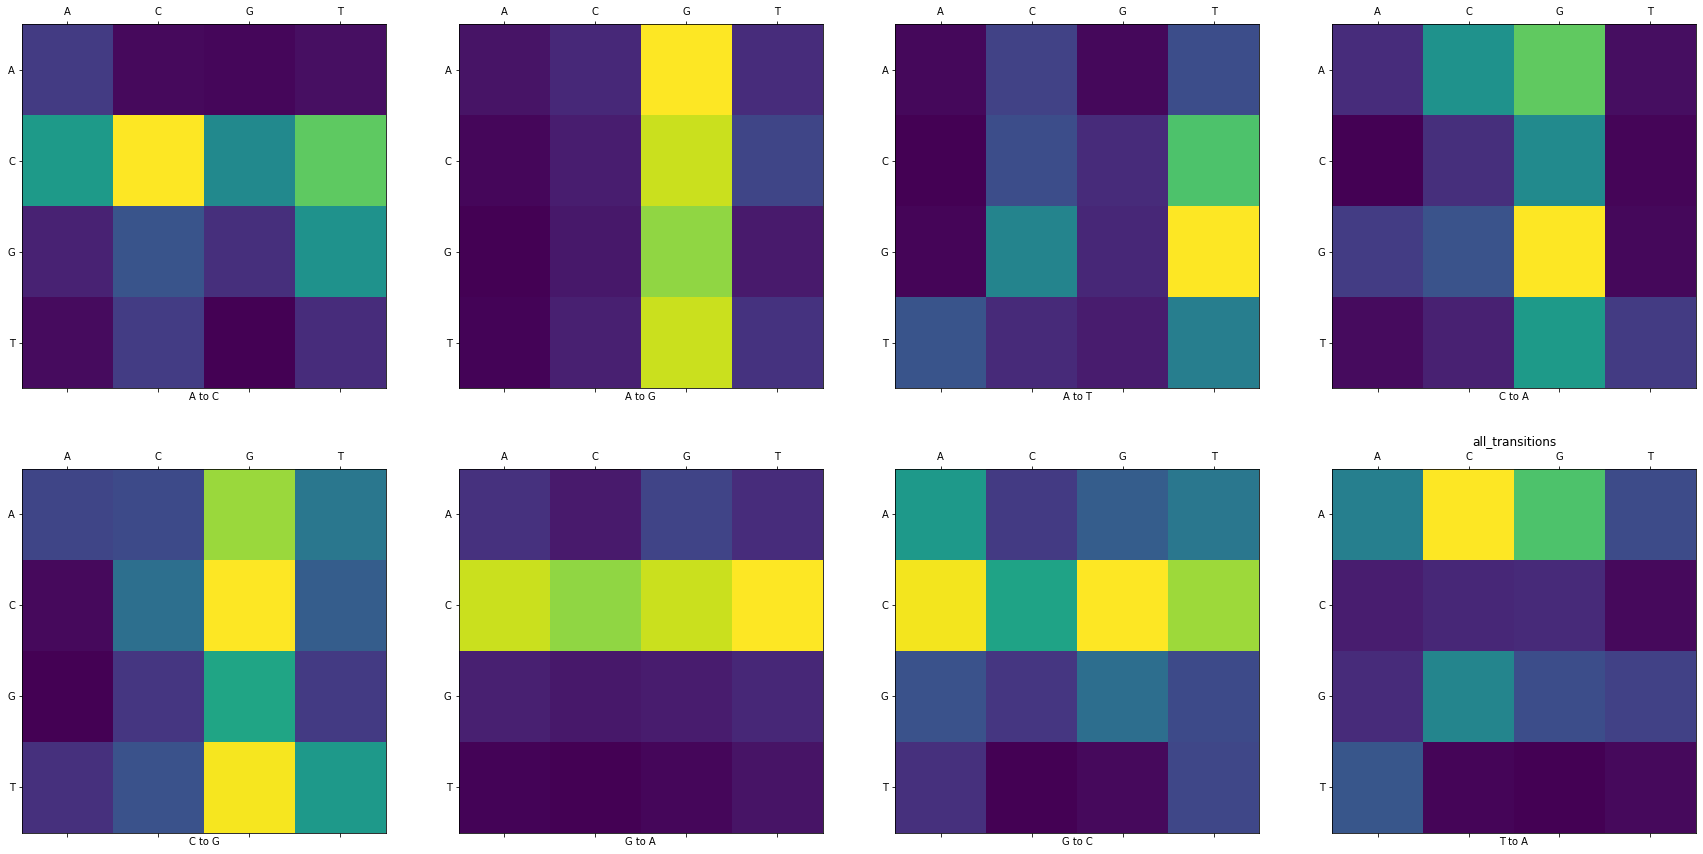

,A,C,G,T
A,0.024012,0.038996,0.031613,0.018712
C,0.014738,0.015612,0.015834,0.013337
G,0.015875,0.024666,0.018873,0.017779
T,0.019675,0.012984,0.012645,0.013306


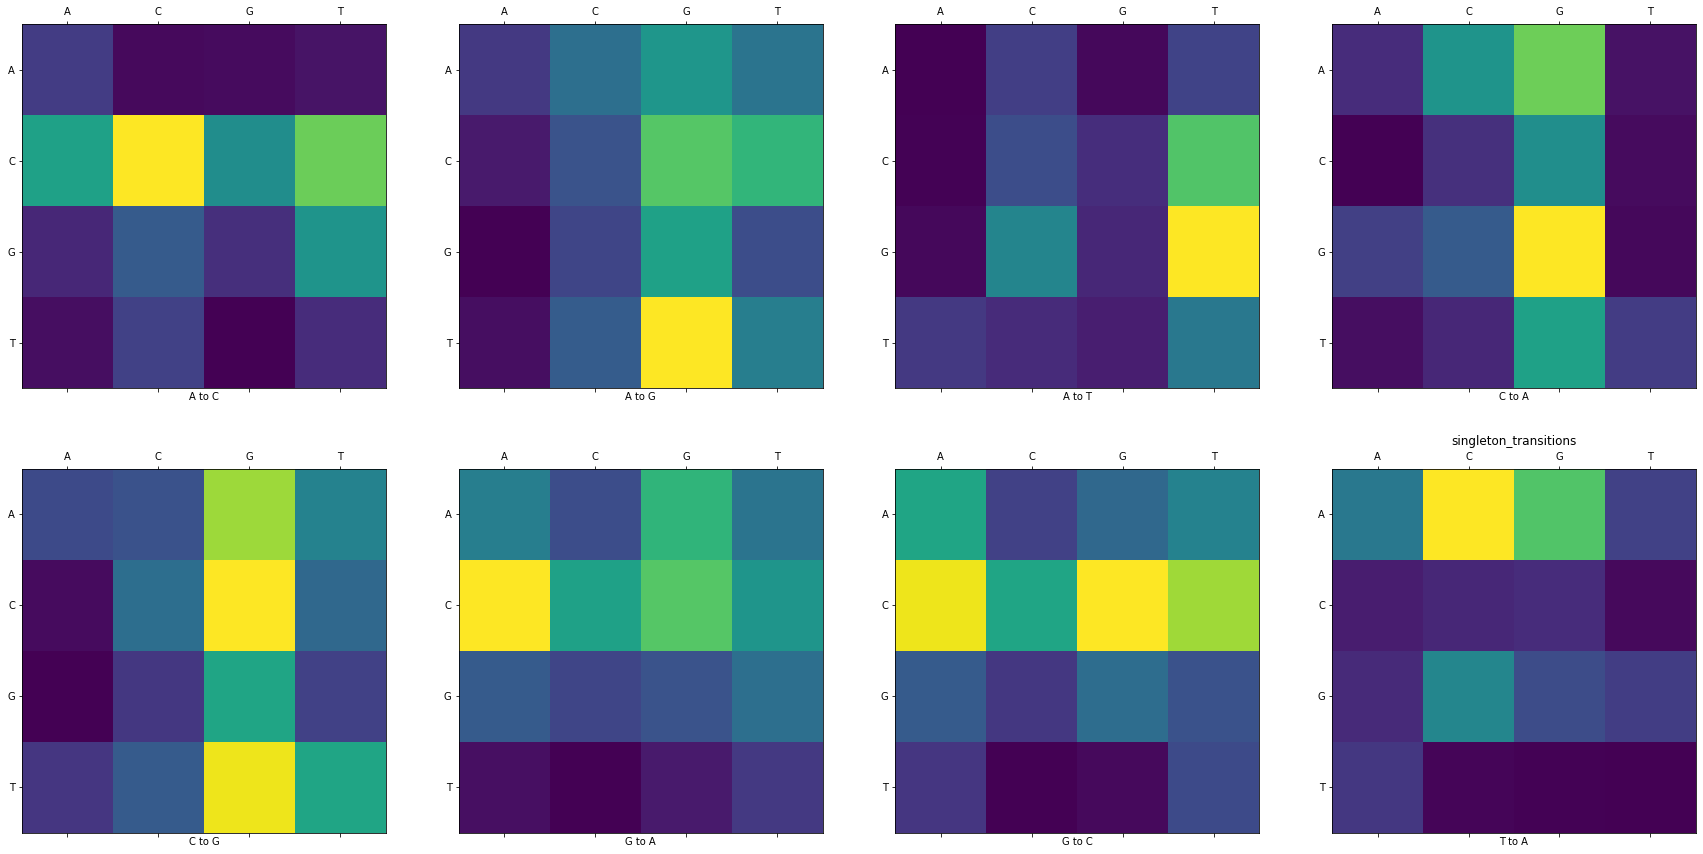

,A,C,G,T
A,0.013200,0.022018,0.018020,0.010169
C,0.008520,0.008984,0.009232,0.007714
G,0.009113,0.014085,0.010754,0.010008
T,0.009713,0.007564,0.007407,0.007348


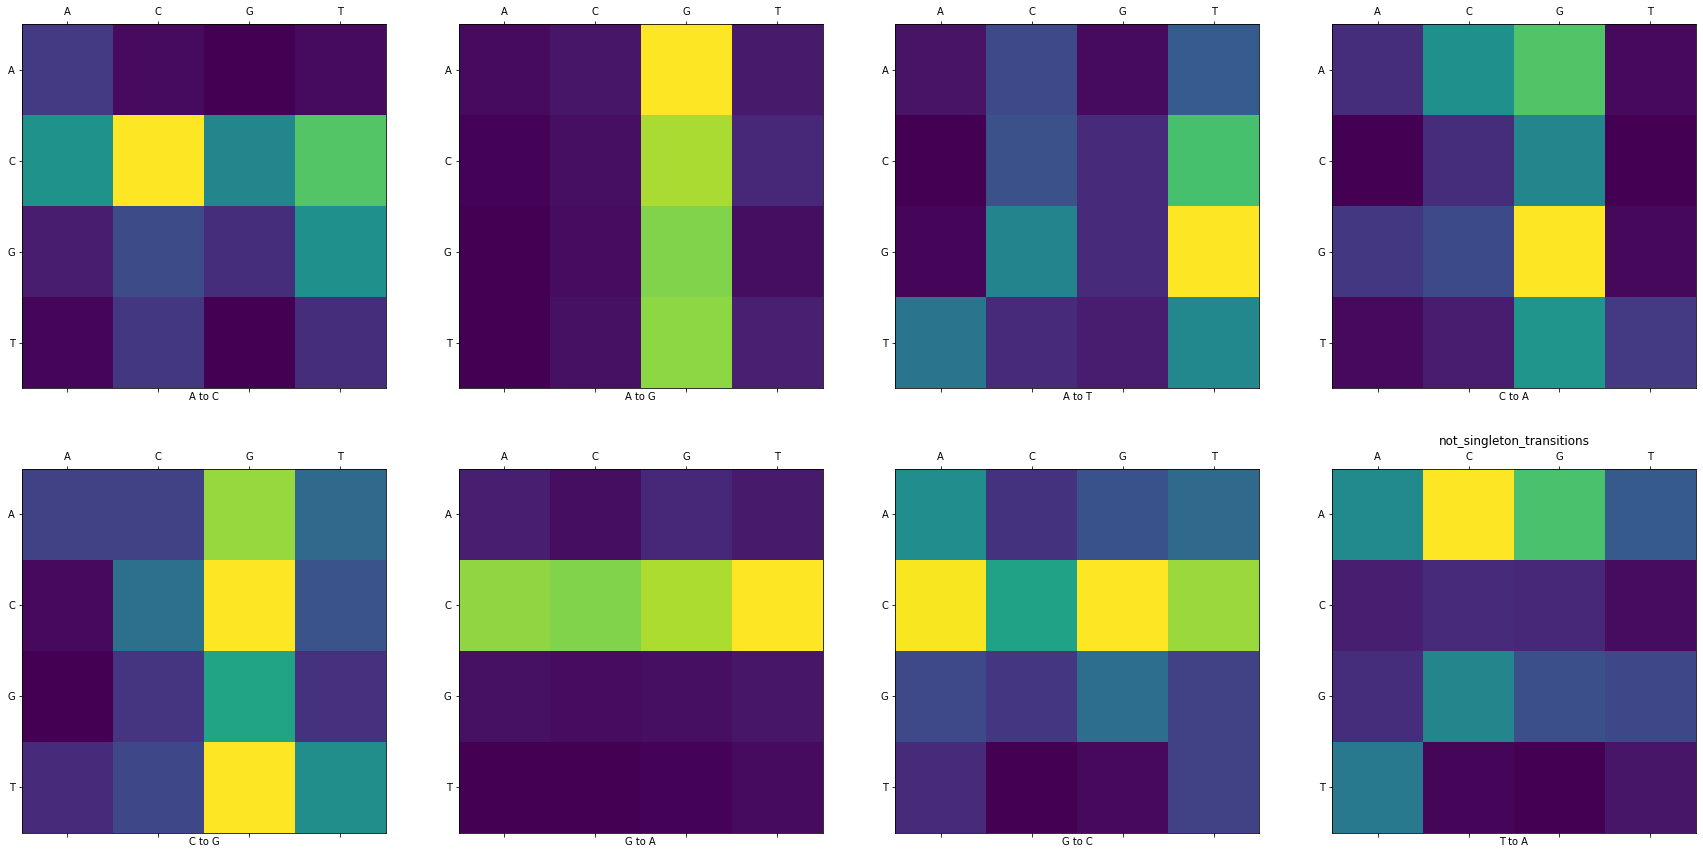

,A,C,G,T
A,0.010812,0.016978,0.013592,0.008543
C,0.006218,0.006628,0.006602,0.005623
G,0.006762,0.010580,0.008119,0.007771
T,0.009962,0.005421,0.005238,0.005958


In [21]:
for name, data in all_all_flanks.items():
    i,j =0,0
    fig, ax = plt.subplots(2,4, figsize=(30, 15))
    for transition, counts in data.items():
        df = pd.DataFrame.from_dict(counts, orient='index')
        df = df.sort_index().reindex(sorted(df.columns), axis=1)
        plt.sca(ax[i,j])
        ax[i,j].matshow(df)
        ax[i,j].set_xlabel(transition[0] + " to " + transition[1])
#         ax[i,j].get_xaxis().set_label([str(n) for n in list(df.columns)])
#         ax[i,j].get_yaxis().set_label([str(n) for n in list(df.index)])
        plt.xticks(range(4), df.columns)
        plt.yticks(range(4), df.index)
        j+=1
        if j == 4:
            i += 1
            j =0
    plt.title(name)
    plt.show()
    display(df)
    


These are the differences when considering singleton variants, non-singleton variants, and all variants.
The following will explore how the same transitions look side by side.

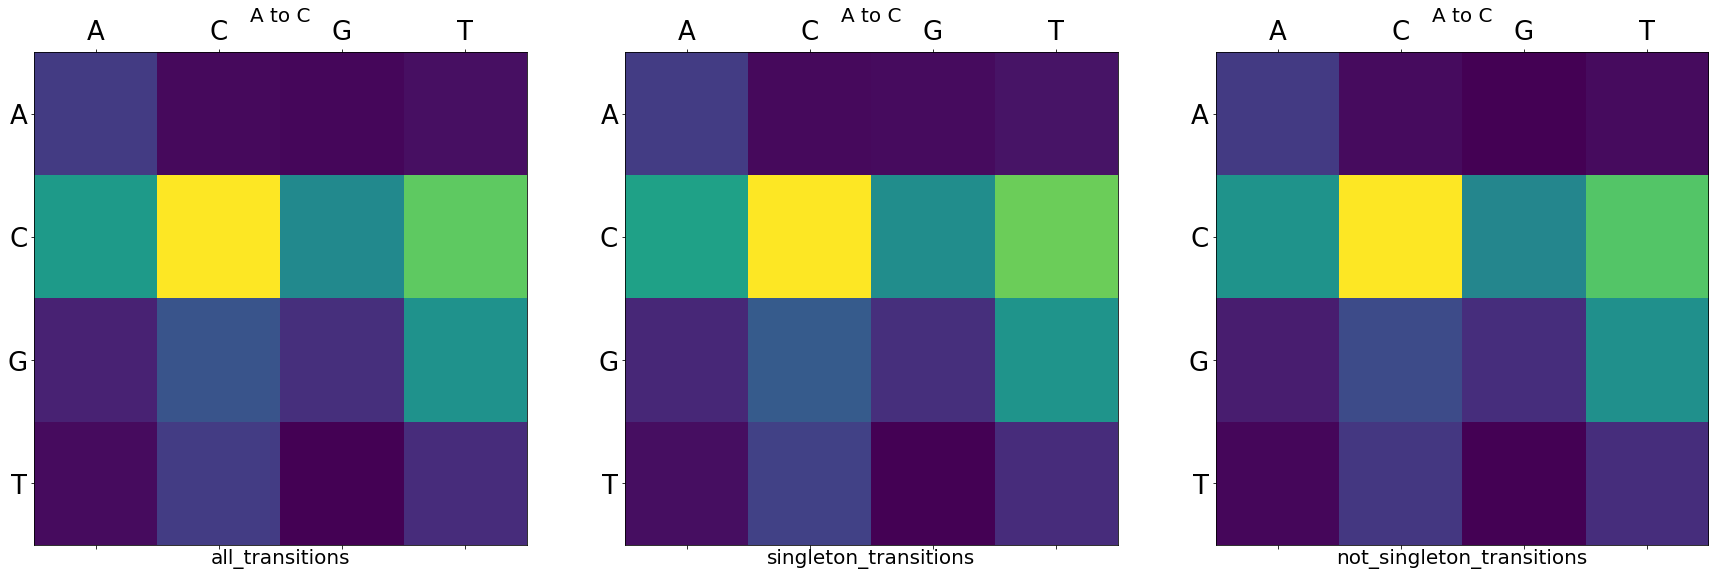

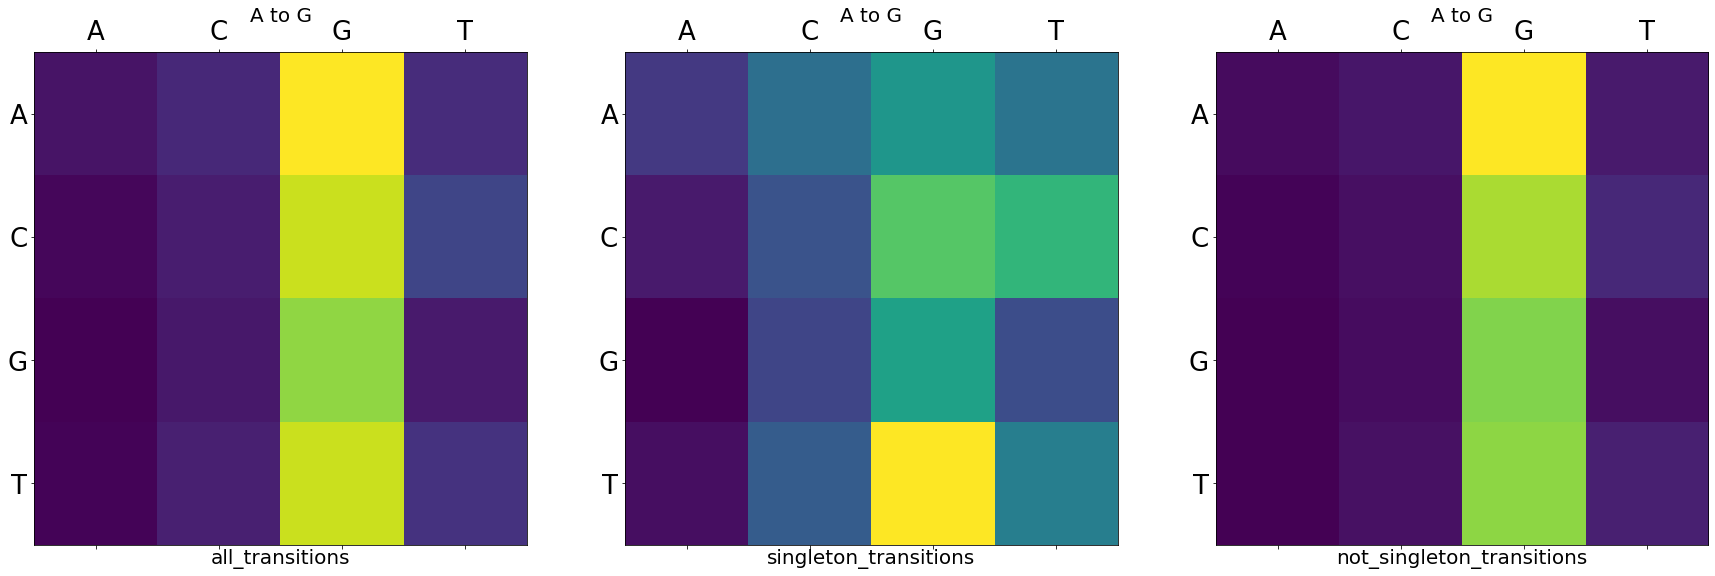

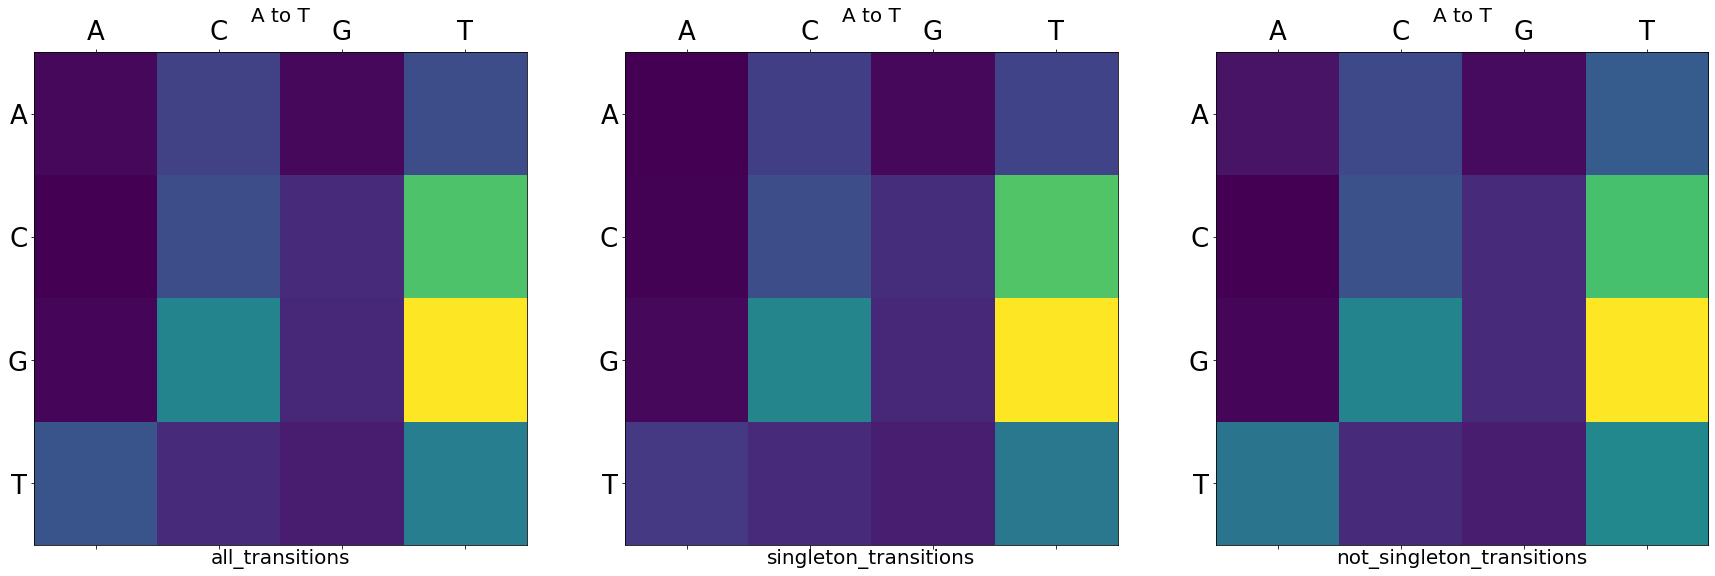

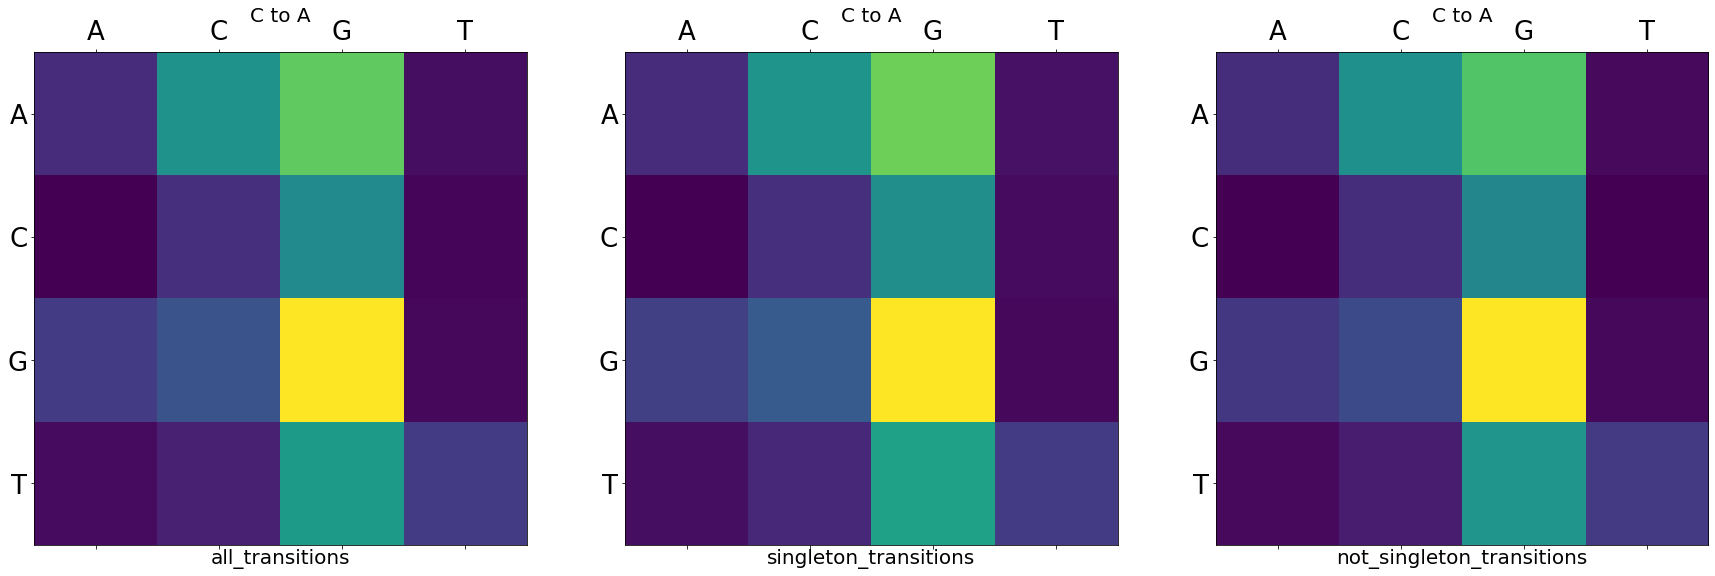

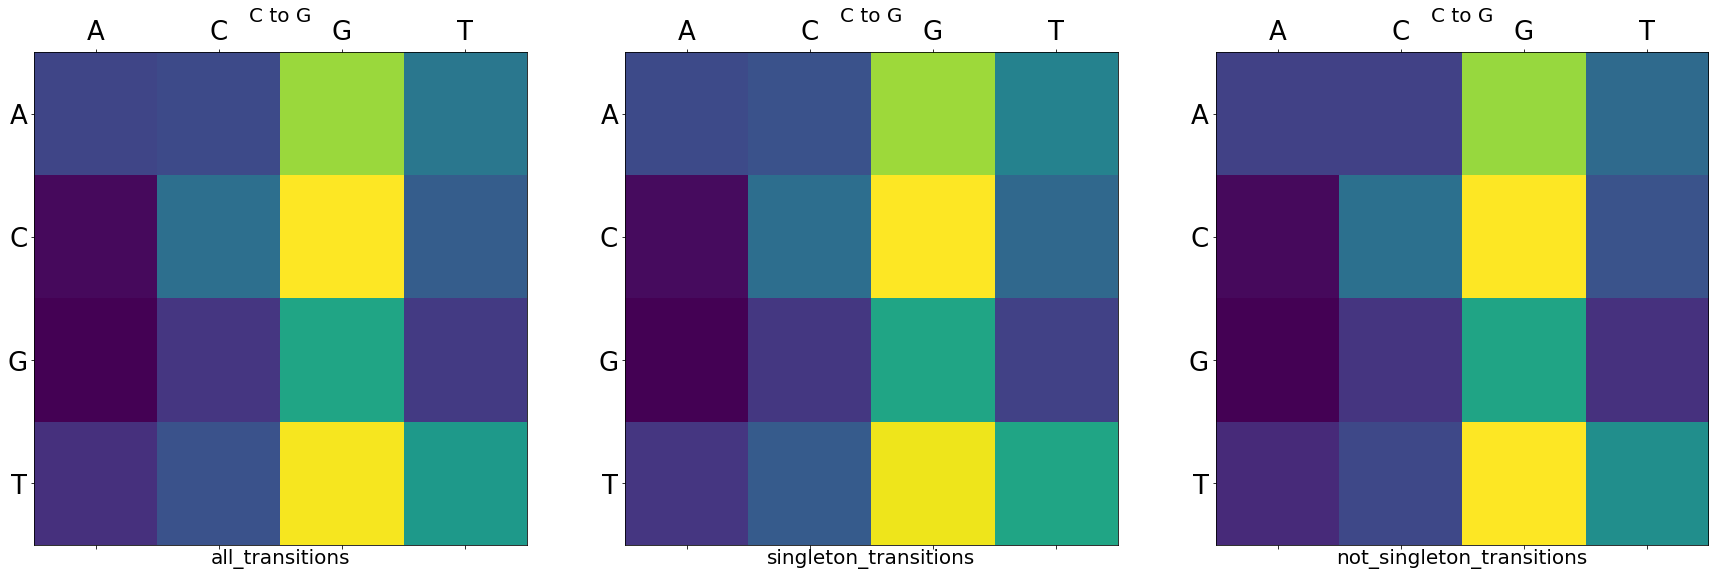

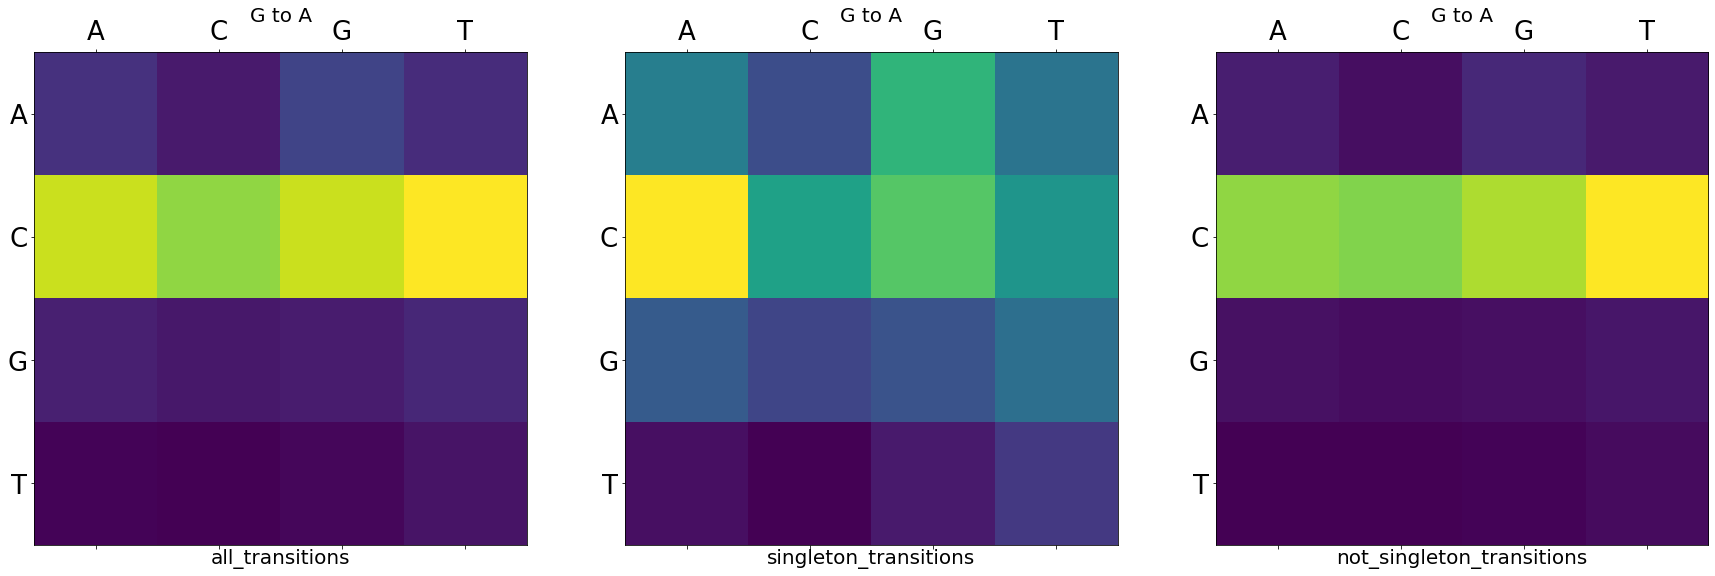

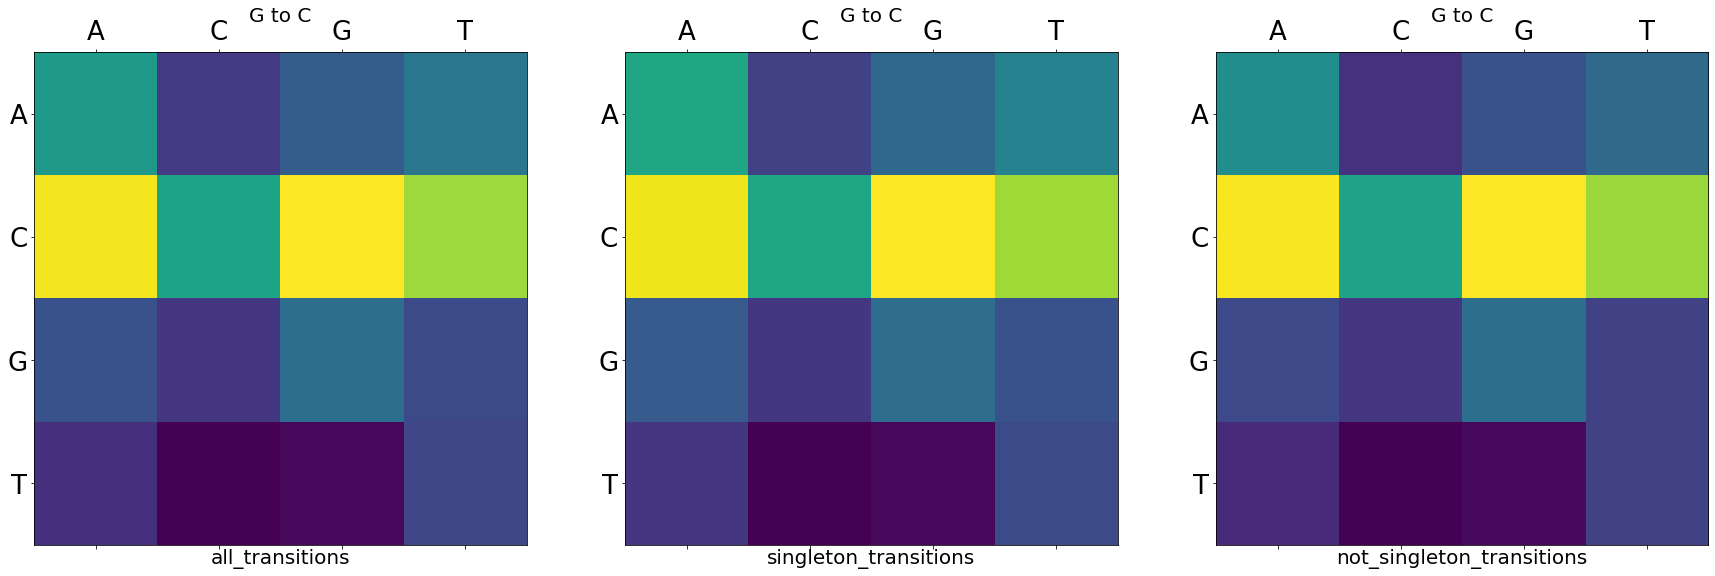

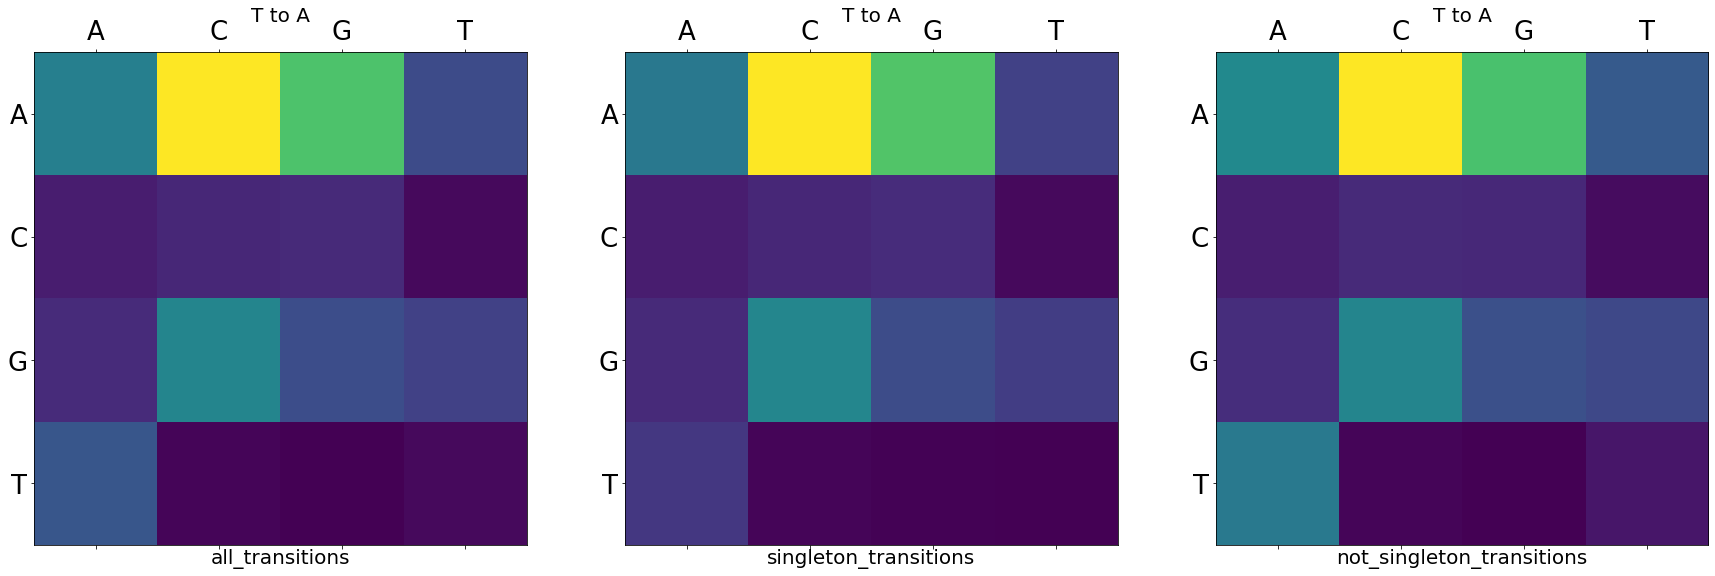

In [26]:
separated_t = defaultdict(lambda: defaultdict(Counter))
for name, data in all_all_flanks.items():
    for index, value in data.items():
        separated_t[index][name] = value
separated_t
figs = []
for tr, value in separated_t.items():
    i = 0
    fig, ax = plt.subplots(1,3, figsize=(30, 10))
    for name, counts in value.items():
        df = pd.DataFrame.from_dict(counts, orient='index')
        df = df.sort_index().reindex(sorted(df.columns), axis=1)
        plt.sca(ax[i])
        ax[i].matshow(df)
        ax[i].set_xlabel(name, fontsize=20)
        plt.xticks(range(4), df.columns, fontsize=26)
        plt.yticks(range(4), df.index, fontsize=26)
        plt.title(tr[0] + " to " + tr[1], fontsize=20)
        #plt.show()
        i += 1
    figs.append(fig)


In [23]:
figs[0].get_axes()[0].title.get_text()

'A to C'

In [24]:
directory = datetime.datetime.now().strftime("transition_profiles_%d%b%Y-%H%M/")
if not os.path.exists(directory):
    os.makedirs(directory)

for figure in figs:
    ft = figure.get_axes()[0].title.get_text()
    figure.savefig(directory+ft+'.png')

In [25]:
# Now I want to average all, sing, and not_sing to visualize the deviation
alla = defaultdict(lambda: defaultdict(Counter))
for tr, ddc in separated_t.items():
    allc = defaultdict(Counter)
    for lf, dd in ddc.items():
        for rf, v in dd.items():
            allc[lf][rf] += v
    alla.append(allc) 
alla

TypeError: unsupported operand type(s) for +=: 'int' and 'Counter'

In [31]:
type(list(list(separated_t.values())[0])[0])

str